## Aim 

The aim of this colab is to familiarise with the following concepts:
* Word embeddings for English and French .
  * Generate word embeddings.
  * Determine the transformation matrices  (X.**R**= Y)

* Translations
  * Linear translations.
  * Testing the linear translation function.

* LSH and document search .
  * Getting the document embeddings .
  * Looking up the tweets.
  * Finding the most similar tweets using LSH.
  * Find the hash value of the tweet.
  * create a hash table.
  * Create all hash tables

In [ ]:
# download the important libraries
import nltk
nltk.download('stopwords')
nltk.download('twitter_samples')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package twitter_samples to /root/nltk_data...
[nltk_data]   Unzipping corpora/twitter_samples.zip.


True

In [ ]:
# Mount the drive to access the relevant data 

from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [ ]:
import pdb
import pickle
import string
import re
import pandas as pd
import time

import gensim
import matplotlib.pyplot as plt
import nltk
import numpy as np
import scipy
import sklearn
from gensim.models import KeyedVectors
from nltk.corpus import stopwords, twitter_samples
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from os import getcwd

In [ ]:
# define some utility functions like to calculate cosine_similarity, process_tweet -> to preprocess the tweet

def process_tweet(tweet):
    
    stemmer = PorterStemmer()
    stopwords_english = stopwords.words('english')
    # remove stock market tickers like $GE
    tweet = re.sub(r'\$\w*', '', tweet)
    # remove old style retweet text "RT"
    tweet = re.sub(r'^RT[\s]+', '', tweet)
    # remove hyperlinks
    tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet)
    # remove hashtags
    # only removing the hash # sign from the word
    tweet = re.sub(r'#', '', tweet)
    # tokenize tweets
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True,
                               reduce_len=True)
    tweet_tokens = tokenizer.tokenize(tweet)

    tweets_clean = []
    for word in tweet_tokens:
        if (word not in stopwords_english and  # remove stopwords
            word not in string.punctuation):  # remove punctuation
            # tweets_clean.append(word)
            stem_word = stemmer.stem(word)  # stemming word
            tweets_clean.append(stem_word)

    return tweets_clean


#this function would store the corresponding French word with an English word.
def get_dict(file_name):
    """
    This function returns the english to french dictionary given a file where the each column corresponds to a word.
    Check out the files this function takes in your workspace.
    """
    my_file = pd.read_csv(file_name, delimiter=' ')
    etof = {}  # the english to french dictionary to be returned
    for i in range(len(my_file)):
        # indexing into the rows.
        en = my_file.loc[i][0]
        fr = my_file.loc[i][1]
        etof[en] = fr

    return etof

# Defining the cosing similarity function to generate cosine relation 
def cosine_similarity(A, B):
    
    # you have to set this variable to the true label.
    cos = -10
    dot = np.dot(A, B)
    norma = np.linalg.norm(A)
    normb = np.linalg.norm(B)
    cos = dot / (norma * normb)

    return 

In [ ]:
# Code cells [10-16] are to process the embeddings data for French and English and convert into a dictionary 
from gensim.models import KeyedVectors

fr_embeddings = KeyedVectors.load_word2vec_format('/content/gdrive/My Drive/wiki.multi.fr.vec')
en_embeddings = KeyedVectors.load_word2vec_format('/content/gdrive/My Drive/GoogleNews-vectors-negative300.bin', binary = True)

In [ ]:
en_fr_train = get_dict('/content/gdrive/My Drive/en-fr.train.txt')
print('The length of the english to french training dictionary is', len(en_fr_train))
en_fr_test = get_dict('/content/gdrive/My Drive/en-fr.test.txt')
print('The length of the english to french test dictionary is', len(en_fr_test))

The length of the english to french training dictionary is 5000
The length of the english to french test dictionary is 1500


In [ ]:
english_set = set(en_embeddings.vocab)
french_set = set(fr_embeddings.vocab)
en_embeddings_subset = {}
fr_embeddings_subset = {}
french_words = set(en_fr_train.values())

In [ ]:
for en_word in en_fr_train.keys():
    fr_word = en_fr_train[en_word]
    if fr_word in french_set and en_word in english_set:
        en_embeddings_subset[en_word] = en_embeddings[en_word]
        fr_embeddings_subset[fr_word] = fr_embeddings[fr_word]


for en_word in en_fr_test.keys():
    fr_word = en_fr_test[en_word]
    if fr_word in french_set and en_word in english_set:
        en_embeddings_subset[en_word] = en_embeddings[en_word]
        fr_embeddings_subset[fr_word] = fr_embeddings[fr_word]

In [ ]:
pickle.dump( en_embeddings_subset, open( "/content/gdrive/My Drive/en_embeddings.p", "wb" ) )
pickle.dump( fr_embeddings_subset, open( "/content/gdrive/My Drive/fr_embeddings.p", "wb" ) )

After processing of the data, now we load the English and French embeddings subset data that we created 


In [ ]:

en_embeddings_subset = pickle.load(open("/content/gdrive/My Drive/en_embeddings.p", "rb"))
fr_embeddings_subset = pickle.load(open("/content/gdrive/My Drive/fr_embeddings.p", "rb"))

In [ ]:
en_fr_train = get_dict('/content/gdrive/My Drive/en-fr.train.txt')
print('The length of the English to French training dictionary is', len(en_fr_train))
en_fr_test = get_dict('/content/gdrive/My Drive/en-fr.test.txt')
print('The length of the English to French test dictionary is', len(en_fr_test))

The length of the English to French training dictionary is 5000
The length of the English to French test dictionary is 1500


## Generate Embedding and transform matrix 

Now we would be implementing the get_matrices function which would take the following as inputs and load matrices X and Y
* en_fr : English to French dictionary 
* en_embeddings : English to embeddings dictionary
* fr_embeddings : French to embeddings dictionary 

Returns : Matrix X and matrix Y, where each row in X is the word embedding for an
english word, and the same row in Y is the word embedding for the French version of that English word.

In [ ]:
def get_matrices(en_fr, french_vecs, english_vecs):
    """
    Input:
        en_fr: English to French dictionary
        french_vecs: French words to their corresponding word embeddings.
        english_vecs: English words to their corresponding word embeddings.
    Output: 
        X: a matrix where the columns are the English embeddings.
        Y: a matrix where the columns correspong to the French embeddings.
        R: the projection matrix that minimizes the F norm ||X R -Y||^2.
    """

    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###

    # X_l and Y_l are lists of the english and french word embeddings
    X_l = list()
    Y_l = list()

    # get the english words (the keys in the dictionary) and store in a set()
    english_set = english_vecs.keys()

    # get the french words (keys in the dictionary) and store in a set()
    french_set = french_vecs.keys()

    # store the french words that are part of the english-french dictionary (these are the values of the dictionary)
    french_words = set(en_fr.values())

    # loop through all english, french word pairs in the english french dictionary
    for en_word, fr_word in en_fr.items():

        # check that the french word has an embedding and that the english word has an embedding
        if fr_word in french_set and en_word in english_set:

            # get the english embedding
            en_vec = english_vecs[en_word]

            # get the french embedding
            fr_vec = french_vecs[fr_word]

            # add the english embedding to the list
            X_l.append(en_vec)

            # add the french embedding to the list
            Y_l.append(fr_vec)

    # stack the vectors of X_l into a matrix X
    X = np.array(X_l)

    # stack the vectors of Y_l into a matrix Y
    Y = np.array(Y_l)
    ### END CODE HERE ###

    return X, Y

In [ ]:
# get the training set matrix
X_train, Y_train = get_matrices(
    en_fr_train, fr_embeddings_subset, en_embeddings_subset)

## Translations 
Convert English to French words using vector space models
### Translation as linear transformation of embeddings
Given dictionaries of English and French word embeddings you will create a transformation matrix R

* Given an English word embedding, e we can multiply eR to get a new word embedding f.
* e and f are row vectors
* We can then compute the nearest neighbors to f in the french embeddings and recommend the word that is most similar to the transformed word embedding.

### Describing translation as the minimization problem 
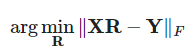

Frobenius norm 

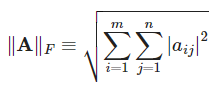

### Actual Loss Function 
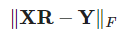

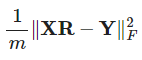


#### Major anecdotes
* The same R is found when using this loss function versus the original Frobenius norm.
* The reason for taking the square is that it's easier to compute the gradient of the squared Frobenius.
* The reason for dividing by m is that we're more interested in the average loss per embedding than the loss for the entire training set.
* The loss for all training set increases with more words (training examples),
so taking the average helps us to track the average loss regardless of the size of the training set.

### Implementation of translation mechanism described in the section 
#### Step1: Computing the Loss
The loss function will be squared Frobenoius norm of the difference between
matrix and its approximation, divided by the number of training examples 
.
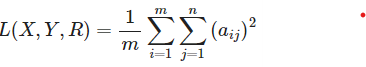



In [ ]:
# define the compute loss function
def compute_loss(X, Y, R):
    '''
    Inputs: 
        X: a matrix of dimension (m,n) where the columns are the English embeddings.
        Y: a matrix of dimension (m,n) where the columns correspong to the French embeddings.
        R: a matrix of dimension (n,n) - transformation matrix from English to French vector space embeddings.
    Outputs:
        L: a matrix of dimension (m,n) - the value of the loss function for given X, Y and R.
    '''
    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    # m is the number of rows in X
    m = len(X)
    
    # diff is XR - Y
    diff = np.dot(X,R) - Y

    # diff_squared is the element-wise square of the difference
    diff_squared = np.square(diff)

    # sum_diff_squared is the sum of the squared elements
    sum_diff_squared = np.sum(diff_squared)

    # loss i the sum_diff_squard divided by the number of examples (m)
    loss = sum_diff_squared / m
    ### END CODE HERE ###
    return loss

### Compute the gradient Loss in respect of transform matrix R
* Calculate the gradient of the loss with respect to transform matrix R.
* The gradient is a matrix that encodes how much a small change in R.

This would give us the gradient direction along which the cost function would minimize with respect to the matrix R .

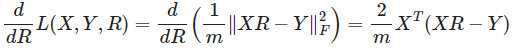

In [ ]:
# Function tot compute the gradient 
def compute_gradient(X, Y, R):
    '''
    Inputs: 
        X: a matrix of dimension (m,n) where the columns are the English embeddings.
        Y: a matrix of dimension (m,n) where the columns correspong to the French embeddings.
        R: a matrix of dimension (n,n) - transformation matrix from English to French vector space embeddings.
    Outputs:
        g: a matrix of dimension (n,n) - gradient of the loss function L for given X, Y and R.
    '''
    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    # m is the number of rows in X
    m = len(X)

    # gradient is X^T(XR - Y) * 2/m
    gradient = np.dot(X.T, ( np.dot(X,R) - Y) )
    gradient = (2* gradient)/m
    ### END CODE HERE ###
    return gradient

## Applying Gradient Descent 

* Earlier, we've mentioned that the gradient of the loss with respect to the matrix encodes how much a tiny change in some coordinate of that matrix affect the change of loss function.

* Gradient descent uses that information to iteratively change matrix R until we reach a point where the loss is minimized.

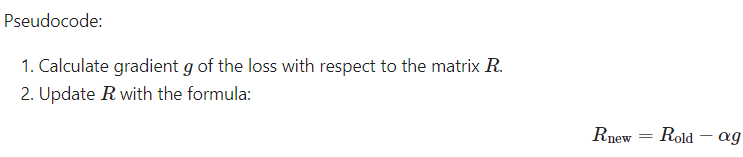

In [ ]:
def align_embeddings(X, Y, train_steps=100, learning_rate=0.0003):
    '''
    Inputs:
        X: a matrix of dimension (m,n) where the columns are the English embeddings.
        Y: a matrix of dimension (m,n) where the columns correspong to the French embeddings.
        train_steps: positive int - describes how many steps will gradient descent algorithm do.
        learning_rate: positive float - describes how big steps will  gradient descent algorithm do.
    Outputs:
        R: a matrix of dimension (n,n) - the projection matrix that minimizes the F norm ||X R -Y||^2
    '''
    np.random.seed(129)

    # the number of columns in X is the number of dimensions for a word vector (e.g. 300)
    # R is a square matrix with length equal to the number of dimensions in th  word embedding
    R = np.random.rand(X.shape[1], X.shape[1])

    for i in range(train_steps):
        if i % 25 == 0:
            print(f"loss at iteration {i} is: {compute_loss(X, Y, R):.4f}")
        
        # use the function that you defined to compute the gradient
        gradient = compute_gradient(X,Y,R)

        # update R by subtracting the learning rate times gradient
        R -= learning_rate * gradient
        ### END CODE HERE ###
    return R

In [ ]:
np.random.seed(129)
m = 10
n = 5
X = np.random.rand(m, n)
Y = np.random.rand(m, n)
R = align_embeddings(X, Y)

loss at iteration 0 is: 1.6050
loss at iteration 25 is: 1.5753
loss at iteration 50 is: 1.5464
loss at iteration 75 is: 1.5183


In [ ]:
R_train = align_embeddings(X_train, Y_train, train_steps=400, learning_rate=0.8)

loss at iteration 0 is: 963.0146
loss at iteration 25 is: 97.8292
loss at iteration 50 is: 26.8329
loss at iteration 75 is: 9.7893
loss at iteration 100 is: 4.3776
loss at iteration 125 is: 2.3281
loss at iteration 150 is: 1.4480
loss at iteration 175 is: 1.0338
loss at iteration 200 is: 0.8251
loss at iteration 225 is: 0.7145
loss at iteration 250 is: 0.6534
loss at iteration 275 is: 0.6185
loss at iteration 300 is: 0.5981
loss at iteration 325 is: 0.5858
loss at iteration 350 is: 0.5782
loss at iteration 375 is: 0.5735


### Testing the translation

## K-Nearest neighbors
* k-NN is a method which takes a vector as input and finds the other vectors in the dataset that are closest to it.
* The 'k' is the number of "nearest neighbors" to find (e.g. k=2 finds the closest two neighbors).

## Searching for the nearest translation of the word .

When searching for translation of an English word we usually gets an approximate and not the absolute response , the KNN algorithm would help here. We can use N=1 based algorithm here.


## Cosine similarity 
* We can obtain distance metric from cosine similarity, but the cosine similarity can't be used directly as the distance metric.
*When the cosine similarity increases (towards 
1), the "distance" between the two vectors decreases .

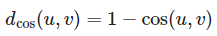




In [ ]:
# Define the nearest_neighbor 
from numpy.linalg import norm

def nearest_neighbor(v, candidates, k=1):
    """
    Input:
      - v, the vector you are going find the nearest neighbor for
      - candidates: a set of vectors where we will find the neighbors
      - k: top k nearest neighbors to find
    Output:
      - k_idx: the indices of the top k closest vectors in sorted form
    """
    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    similarity_l = []

    # for each candidate vector...
    for row in candidates:
        # get the cosine similarity
        cos_similarity = np.dot(row,v) / (norm(row) * norm(v))

        # append the similarity to the list
        similarity_l.append(cos_similarity)

    # sort the similarity list and get the indices of the sorted list
    sorted_ids = np.argsort(similarity_l)

    # get the indices of the k most similar candidate vectors , Remember to pick lowest value based on the distant and the highest based on the cosine similarity
    k_idx = sorted_ids[-k:]
    ### END CODE HERE ###
    return k_idx

In [ ]:
v = np.array([1, 0, 1])
candidates = np.array([[1, 0, 5], [-2, 5, 3], [2, 0, 1], [6, -9, 5], [9, 9, 9]])
print(candidates[nearest_neighbor(v, candidates, 3)])

[[9 9 9]
 [1 0 5]
 [2 0 1]]


### Testing the translation and compute it's accuracy
Now we would be testing the accuracy of the model 

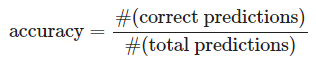

In [ ]:
def test_vocabulary(X, Y, R):
    '''
    Input:
        X: a matrix where the columns are the English embeddings.
        Y: a matrix where the columns correspong to the French embeddings.
        R: the transform matrix which translates word embeddings from
        English to French word vector space.
    Output:
        accuracy: for the English to French capitals
    '''

    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    # The prediction is X times R
    pred = np.dot(X,R)

    # initialize the number correct to zero
    num_correct = 0

    # loop through each row in pred (each transformed embedding)
    for i in range(len(pred)):
        # get the index of the nearest neighbor of pred at row 'i'; also pass in the candidates in Y
        pred_idx = nearest_neighbor(pred[i],Y)

        # if the index of the nearest neighbor equals the row of i... \
        if pred_idx == i:
            # increment the number correct by 1.
            num_correct += 1

    # accuracy is the number correct divided by the number of rows in 'pred' (also number of rows in X)
    accuracy = num_correct / len(pred)

    ### END CODE HERE ###

    return accuracy

In [ ]:
X_val, Y_val = get_matrices(en_fr_test, fr_embeddings_subset, en_embeddings_subset)

In [ ]:
acc = test_vocabulary(X_val, Y_val, R_train)  # this might take a minute or two
print(f"accuracy on test set is {acc:.3f}")

accuracy on test set is 0.557


### LSH and Dcoument Search 

* Now we will implement a better version of KNN with locality sensitive hashing(LSH) .
*

In [ ]:
# get the positive and negative tweets
all_positive_tweets = twitter_samples.strings('positive_tweets.json')
all_negative_tweets = twitter_samples.strings('negative_tweets.json')
all_tweets = all_positive_tweets + all_negative_tweets

### Get document embedding 
## Bag of words document model 
* ordering of words can change the meaning of the sentence and it's interpretation and thus the output but it allows us to train the model faster with lesser resources.

## Document embeddings 
* Document embedding is created by summing up the embeddings of all words
in the document.
* If we don't know the embedding of some word, we can ignore that word.


We performed the following steps while creating the document embedding :
* The function get_document_embedding() encodes entire document as a "document" embedding.
* It takes in a docoument (as a string) and a dictionary, en_embeddings.
* It processes the document, and looks up the corresponding embedding of each word.
* It then sums them up and returns the sum of all word vectors of that processed tweet.

In [ ]:
def get_document_embedding(tweet, en_embeddings): 
    '''
    Input:
        - tweet: a string
        - en_embeddings: a dictionary of word embeddings
    Output:
        - doc_embedding: sum of all word embeddings in the tweet
    '''
    doc_embedding = np.zeros(300)

    # process the document into a list of words (process the tweet)
    processed_doc = process_tweet(tweet)
    
    
    return doc_embedding

In [ ]:
# testing the above function
custom_tweet = "RT @Twitter @chapagain Hello There! Have a great day. :) #good #morning http://chapagain.com.np"
tweet_embedding = get_document_embedding(custom_tweet, en_embeddings_subset)
tweet_embedding[-5:]

array([0., 0., 0., 0., 0.])

### Store All the document embedings in a Dictionary 


In [ ]:
def get_document_vecs(all_docs, en_embeddings):
    '''
    Input:
        - all_docs: list of strings - all tweets in our dataset.
        - en_embeddings: dictionary with words as the keys and their embeddings as the values.
    Output:
        - document_vec_matrix: matrix of tweet embeddings.
        - ind2Doc_dict: dictionary with indices of tweets in vecs as keys and their embeddings as the values.
    '''

    # the dictionary's key is an index (integer) that identifies a specific tweet
    # the value is the document embedding for that document
    ind2Doc_dict = {}

    # this is list that will store the document vectors
    document_vec_l = []

    for i, doc in enumerate(all_docs):

        # get the document embedding of the tweet
        doc_embedding = get_document_embedding(doc, en_embeddings)

        # save the document embedding into the ind2Tweet dictionary at index i
        ind2Doc_dict[i] = doc_embedding

        # append the document embedding to the list of document vectors
        document_vec_l.append(doc_embedding)

        ### END CODE HERE ###

    # convert the list of document vectors into a 2D array (each row is a document vector)
    document_vec_matrix = np.vstack(document_vec_l)

    return document_vec_matrix, ind2Doc_dict

In [ ]:
document_vecs, ind2Tweet = get_document_vecs(all_tweets, en_embeddings_subset)

In [ ]:
print(f"length of dictionary {len(ind2Tweet)}")
print(f"shape of document_vecs {document_vecs.shape}")

length of dictionary 10000
shape of document_vecs (10000, 300)


### Looking up the tweets
Now you have a vector of dimension (m,d) where m is the number of tweets (10,000) and d is the dimension of the embeddings (300). Now you will input a tweet, and use cosine similarity to see which tweet in our corpus is similar to your tweet.

In [ ]:
my_tweet = 'i am sad'
process_tweet(my_tweet)
tweet_embedding = get_document_embedding(my_tweet, en_embeddings_subset)

In [ ]:
idx = np.argmax(cosine_similarity(document_vecs, tweet_embedding))
print(all_tweets[idx])

#FollowFriday @France_Inte @PKuchly57 @Milipol_Paris for being top engaged members in my community this week :)


<ipython-input-4-14e052b32d22>:67: RuntimeWarning: invalid value encountered in true_divide
  cos = dot / (norma * normb)


In [ ]:
N_VECS = len(all_tweets)       # This many vectors.
N_DIMS = len(ind2Tweet[1])     # Vector dimensionality.
print(f"Number of vectors is {N_VECS} and each has {N_DIMS} dimensions.")

Number of vectors is 10000 and each has 300 dimensions.


### Implement Locality Sensitive Hashing to find the most similar tweets

## Choosing the number of planes 
* Each plane divides the space into 2 parts.
* Thus n planes would divide the space into 2^n parts.
* We want to organize 10,000 document vectors into buckets so that every bucket has about 16 vectors.
* For that we need 10000/16 = 625 buckets.
* We're interested in n the number of planes so that 2^n = 625

In [ ]:
# The number of planes. We use log2(625) to have ~16 vectors/bucket.
N_PLANES = 10
# Number of times to repeat the hashing to improve the search.
N_UNIVERSES = 25

## Getting the Hash number of a vector 
Each vector needs to be assigned a unique number to segment in one of the buckets.

## Properties of HyperPlane in a space 

* In 3 dimensional vector space the hyperplane is a plane but in the 2 dimensional space the hyperplane is a line.
* Generally, the hyperplane is subspace which has dimension 1 lower than the original vector space has.
* Hyperplane is determined by the normal vector.
* A normal vector n of the plane p is the vector to which all the vectors in the plane p are orthogonal.

## Using Hyperspace to split the planes 
*  All vectors with >0 dot product with the normal vector would lie on one side of the plane while the rest would lie on other side of the plane.


## Encoding the Hash bucket 
* First take the dot product with each plane , than use this information to generate a unique ID for the vector.
* We need to determine a function which would restrict collision of ID from different set of dot product planes .
* Thus we would use sum(2^i) function where i =1 when the dot product of the vector with the plane = 1 else it is not taken in the ID value.

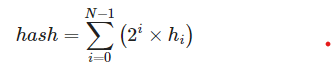



In [ ]:
# Dividing the vector space into different planes .

np.random.seed(0)
planes_l = [np.random.normal(size=(N_DIMS, N_PLANES))
            for _ in range(N_UNIVERSES)]

In [ ]:
def hash_value_of_vector(v, planes):
    """Create a hash for a vector; hash_id says which random hash to use.
    Input:
        - v:  vector of tweet. It's dimension is (1, N_DIMS)
        - planes: matrix of dimension (N_DIMS, N_PLANES) - the set of planes that divide up the region
    Output:
        - res: a number which is used as a hash for your vector

    """
   
    # for the set of planes,
    # calculate the dot product between the vector and the matrix containing the planes
    # remember that planes has shape (300, 10)
    # The dot product will have the shape (1,10)
    dot_product = np.dot(v,planes)

    # get the sign of the dot product (1,10) shaped vector
    sign_of_dot_product = np.sign(dot_product)

    # set h to be false (eqivalent to 0 when used in operations) if the sign is negative,
    # and true (equivalent to 1) if the sign is positive (1,10) shaped vector
    h = sign_of_dot_product >= 0

    # remove extra un-used dimensions (convert this from a 2D to a 1D array)
    h = np.squeeze(h)

    # initialize the hash value to 0
    hash_value = 0

    n_planes = planes.shape[1]
    for i in range(n_planes):
        # increment the hash value by 2^i * h_i
        hash_value += np.power(2,i) * h[i]
   

    # cast hash_value as an integer
    hash_value = int(hash_value)

    return hash_value

In [ ]:
np.random.seed(0)
idx = 0
planes = planes_l[idx]  # get one 'universe' of planes to test the function
vec = np.random.rand(1, 300)
print(f" The hash value for this vector,",
      f"and the set of planes at index {idx},",
      f"is {hash_value_of_vector(vec, planes)}")

 The hash value for this vector, and the set of planes at index 0, is 768


## Creating a Hash table

* We can create a Hash table such that given a Hash ID we can quickly find the corresponding vectors . 
* Now we would create a Hash_table to store similar vectors together and id_table to map which vectors corresponds to what tweets .


In [ ]:
def make_hash_table(vecs, planes):
    """
    Input:
        - vecs: list of vectors to be hashed.
        - planes: the matrix of planes in a single "universe", with shape (embedding dimensions, number of planes).
    Output:
        - hash_table: dictionary - keys are hashes, values are lists of vectors (hash buckets)
        - id_table: dictionary - keys are hashes, values are list of vectors id's
                            (it's used to know which tweet corresponds to the hashed vector)
    """
    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###

    # number of planes is the number of columns in the planes matrix
    num_of_planes = planes.shape[1]

    # number of buckets is 2^(number of planes)
    num_buckets = np.power(2,num_of_planes)

    # create the hash table as a dictionary.
    # Keys are integers (0,1,2.. number of buckets)
    # Values are empty lists
    hash_table = dict({i:[] for i in range(num_buckets)})

    # create the id table as a dictionary.
    # Keys are integers (0,1,2... number of buckets)
    # Values are empty lists
    id_table = dict({i:[] for i in range(num_buckets)})

    # for each vector in 'vecs'
    for i, v in enumerate(vecs):
        # calculate the hash value for the vector
        h = hash_value_of_vector(v, planes)

        # store the vector into hash_table at key h,
        # by appending the vector v to the list at key h
        hash_table[h].append(v)

        # store the vector's index 'i' (each document is given a unique integer 0,1,2...)
        # the key is the h, and the 'i' is appended to the list at key h
        id_table[h].append(i)

    ### END CODE HERE ###

    return hash_table, id_table

In [ ]:
# Testing the function
np.random.seed(0)
planes = planes_l[0]  # get one 'universe' of planes to test the function
vec = np.random.rand(1, 300)
tmp_hash_table, tmp_id_table = make_hash_table(document_vecs, planes)

print(f"The hash table at key 0 has {len(tmp_hash_table[0])} document vectors")
print(f"The id table at key 0 has {len(tmp_id_table[0])}")
print(f"The first 5 document indices stored at key 0 of are {tmp_id_table[0][0:5]}")

The hash table at key 0 has 0 document vectors
The id table at key 0 has 0
The first 5 document indices stored at key 0 of are []


## Approximate KNN with LSH 
Implement approximate K nearest neighbors using locality sensitive hashing, to search for documents that are similar to a given document at the index doc_id



In [ ]:
def approximate_knn(doc_id, v, planes_l, k=1, num_universes_to_use=N_UNIVERSES):
    """Search for k-NN using hashes."""
    assert num_universes_to_use <= N_UNIVERSES

    # Vectors that will be checked as possible nearest neighbor
    vecs_to_consider_l = list()

    # list of document IDs
    ids_to_consider_l = list()

    # create a set for ids to consider, for faster checking if a document ID already exists in the set
    ids_to_consider_set = set()

    # loop through the universes of planes
    for universe_id in range(num_universes_to_use):

        # get the set of planes from the planes_l list, for this particular universe_id
        planes = planes_l[universe_id]

        # get the hash value of the vector for this set of planes
        hash_value = hash_value_of_vector(v, planes)

        # get the hash table for this particular universe_id
        hash_table = hash_tables[universe_id]

        # get the list of document vectors for this hash table, where the key is the hash_value
        document_vectors_l = hash_table[hash_value]

        # get the id_table for this particular universe_id
        id_table = id_tables[universe_id]

        # get the subset of documents to consider as nearest neighbors from this id_table dictionary
        new_ids_to_consider = id_table[hash_value]

        ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###

        # remove the id of the document that we're searching
        if doc_id in new_ids_to_consider:
            new_ids_to_consider.remove(doc_id)
            print(f"removed doc_id {doc_id} of input vector from new_ids_to_search")

        # loop through the subset of document vectors to consider
        for i, new_id in enumerate(new_ids_to_consider):

            # if the document ID is not yet in the set ids_to_consider...
            if new_id not in ids_to_consider_set:
                # access document_vectors_l list at index i to get the embedding
                # then append it to the list of vectors to consider as possible nearest neighbors
                document_vector_at_i = document_vectors_l[i]

                # append the new_id (the index for the document) to the list of ids to consider
                vecs_to_consider_l.append(document_vector_at_i)
                ids_to_consider_l.append(new_id)

                # also add the new_id to the set of ids to consider
                # (use this to check if new_id is not already in the IDs to consider)
                ids_to_consider_set.add(new_id)

        ### END CODE HERE ###

    # Now run k-NN on the smaller set of vecs-to-consider.
    print("Fast considering %d vecs" % len(vecs_to_consider_l))

    # convert the vecs to consider set to a list, then to a numpy array
    vecs_to_consider_arr = np.array(vecs_to_consider_l)

    # call nearest neighbors on the reduced list of candidate vectors
    nearest_neighbor_idx_l = nearest_neighbor(v, vecs_to_consider_arr, k=k)

    # Use the nearest neighbor index list as indices into the ids to consider
    # create a list of nearest neighbors by the document ids
    nearest_neighbor_ids = [ids_to_consider_l[idx]
                            for idx in nearest_neighbor_idx_l]

    return nearest_neighbor_ids

In [ ]:
doc_id = 0
doc_to_search = all_tweets[doc_id]
vec_to_search = document_vecs[doc_id]
nearest_neighbor_ids = approximate_knn(
    doc_id, vec_to_search, planes_l, k=3, num_universes_to_use=5)

NameError: ignored